In [13]:
import os

def trim_rtt_file(input_file, max_lines=2000):
    """
    Trim RTT data file to keep header + first max_lines lines.
    Handles files shorter than max_lines gracefully.
    
    Args:
        input_file (str): Input file path
        max_lines (int): Maximum lines to keep after header
    """
    base, ext = os.path.splitext(input_file)
    output_file = f'{base}_trimmed{ext}'
    
    try:
        with open(input_file, 'r') as f_in:
            # Keep header line
            header = f_in.readline()
            
            # Read up to max_lines, handling shorter files
            lines = []
            for _ in range(max_lines):
                try:
                    lines.append(next(f_in))
                except StopIteration:
                    break
            
            # Write trimmed data
            with open(output_file, 'w') as f_out:
                f_out.write(header)
                f_out.writelines(lines)
                
        print(f'Successfully trimmed {input_file}')
        
    except FileNotFoundError:
        print(f'Error: Could not find file {input_file}')
    except Exception as e:
        print(f'Error processing {input_file}: {str(e)}')

# Process RTT files
files = ['rtt_spade.csv', 'rtt_jade.csv', 'rtt_madkit.csv']
for f in files:
    trim_rtt_file(f)

Successfully trimmed rtt_spade.csv
Successfully trimmed rtt_jade.csv
Successfully trimmed rtt_madkit.csv


Error procesando archivo rtt_madkit_trimmed.csv: Error tokenizing data. C error: Expected 7 fields in line 2, saw 8


Estadísticas MadKit:
mean: 0.00ms
std: 0.00ms
max: 0.00ms
min: 0.00ms

Estadísticas SPADE:
mean: 0.00ms
std: 0.00ms
max: 0.00ms
min: 0.00ms


C:\Users\Gonza\AppData\Local\Temp\ipykernel_15836\2242604710.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


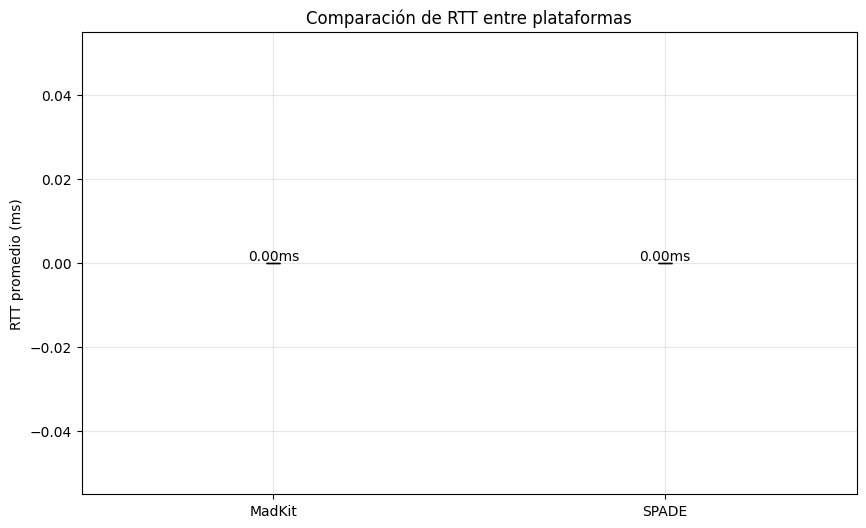

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def process_rtt_file(file_path):
    """
    Procesa un archivo RTT extrayendo solo Timestamp y AgentId.
    
    Args:
        file_path (str): Ruta al archivo CSV
        
    Returns:
        pd.DataFrame: DataFrame con las columnas timestamp y deltas de tiempo por agente
    """
    try:
        # Leer solo las columnas necesarias
        df = pd.read_csv(file_path, usecols=['Timestamp', 'AgentId'])
        
        # Convertir timestamp a datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        # Ordenar por agente y timestamp
        df = df.sort_values(['AgentId', 'Timestamp'])
        
        # Calcular deltas de tiempo por agente
        df['delta_ms'] = df.groupby('AgentId')['Timestamp'].diff().dt.total_seconds() * 1000
        
        # Limpiar valores NaN y negativos
        df['delta_ms'] = df['delta_ms'].fillna(0).clip(lower=0)
        
        return df
        
    except ValueError as e:
        # Si las columnas no están en el header, intentar inferir su posición
        try:
            # Leer el archivo sin header y asignar nombres
            df = pd.read_csv(file_path, header=None)
            
            # Encontrar las columnas que parecen timestamp y agentId
            timestamp_col = None
            agent_col = None
            
            # Buscar en las primeras filas de cada columna
            for col in df.columns:
                sample = df[col].head()
                # Buscar timestamps
                if any(str(x).count(':') >= 2 for x in sample):
                    timestamp_col = col
                # Buscar IDs de agentes (asumiendo que contienen letras)
                elif any(str(x).isalpha() for x in sample):
                    agent_col = col
            
            if timestamp_col is not None and agent_col is not None:
                # Crear nuevo DataFrame con las columnas identificadas
                result_df = pd.DataFrame({
                    'Timestamp': df[timestamp_col],
                    'AgentId': df[agent_col]
                })
                
                # Procesar igual que antes
                result_df['Timestamp'] = pd.to_datetime(result_df['Timestamp'])
                result_df = result_df.sort_values(['AgentId', 'Timestamp'])
                result_df['delta_ms'] = result_df.groupby('AgentId')['Timestamp'].diff().dt.total_seconds() * 1000
                result_df['delta_ms'] = result_df['delta_ms'].fillna(0).clip(lower=0)
                
                return result_df
                
        except Exception as inner_e:
            print(f"Error procesando archivo {file_path}: {str(inner_e)}")
            return None
            
    except Exception as e:
        print(f"Error procesando archivo {file_path}: {str(e)}")
        return None

def calculate_statistics(df):
    """
    Calcula estadísticas básicas de los deltas de tiempo.
    """
    if df is None or df.empty:
        return {
            'mean': 0,
            'std': 0,
            'max': 0,
            'min': 0
        }
    
    stats = {
        'mean': df['delta_ms'].mean(),
        'std': df['delta_ms'].std(),
        'max': df['delta_ms'].max(),
        'min': df['delta_ms'].min()
    }
    
    return {k: round(v, 2) if not pd.isna(v) else 0 for k, v in stats.items()}

def analyze_rtt_data(madkit_path, spade_path):
    """
    Analiza los datos RTT de ambos archivos.
    
    Args:
        madkit_path (str): Ruta al archivo MadKit
        spade_path (str): Ruta al archivo SPADE
        
    Returns:
        tuple: (madkit_deltas, spade_deltas, madkit_stats, spade_stats)
    """
    # Procesar archivos
    madkit_df = process_rtt_file(madkit_path)
    spade_df = process_rtt_file(spade_path)
    
    # Calcular estadísticas
    madkit_stats = calculate_statistics(madkit_df)
    spade_stats = calculate_statistics(spade_df)
    
    return madkit_df, spade_df, madkit_stats, spade_stats

def plot_comparison(madkit_stats, spade_stats):
    """
    Genera un gráfico comparativo de RTT.
    """
    platforms = ['MadKit', 'SPADE']
    means = [madkit_stats['mean'], spade_stats['mean']]
    stds = [madkit_stats['std'], spade_stats['std']]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(platforms, means, yerr=stds, capsize=5)
    
    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms', ha='center', va='bottom')
    
    plt.title('Comparación de RTT entre plataformas')
    plt.ylabel('RTT promedio (ms)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    madkit_path = 'rtt_madkit_trimmed.csv'
    spade_path = 'rtt_spade_trimmed.csv'
    
    # Procesar datos
    madkit_df, spade_df, madkit_stats, spade_stats = analyze_rtt_data(
        madkit_path, spade_path
    )
    
    # Mostrar estadísticas
    for framework, stats in [("MadKit", madkit_stats), ("SPADE", spade_stats)]:
        print(f"\nEstadísticas {framework}:")
        for metric, value in stats.items():
            print(f"{metric}: {value:.2f}ms")
    
    # Generar gráfico
    plot_comparison(madkit_stats, spade_stats)